## Model Training (needs GPU)

In [ ]:
# ──────────────────────────────────────────────────────────────────────
# 0  Imports & global settings
# ──────────────────────────────────────────────────────────────────────
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks  import EarlyStopping


SEED = 26
np.random.seed(SEED)
tf.random.set_seed(SEED)


# ──────────────────────────────────────────────────────────────────────
# 1  Water-level time-series – daily, continuous
# ──────────────────────────────────────────────────────────────────────
DATA_PATH = Path("../data/processed/water_levels_daily.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found.")

df_lvl = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])

daily_levels = (
    df_lvl.set_index("timestamp")["value"]
           .resample("D").mean()
           .interpolate()                       # close tiny gaps if any
)

daily_df = daily_levels.to_frame(name="value")


# ──────────────────────────────────────────────────────────────────────
# 2  Calendar (deterministic) features
# ──────────────────────────────────────────────────────────────────────
doy     = daily_df.index.dayofyear
ang_yr  = 2 * np.pi * doy / 365.25
dow     = daily_df.index.dayofweek
ang_wk  = 2 * np.pi * dow / 7

daily_df["sin365"] = np.sin(ang_yr)
daily_df["cos365"] = np.cos(ang_yr)
daily_df["sin7"]   = np.sin(ang_wk)
daily_df["cos7"]   = np.cos(ang_wk)


# ──────────────────────────────────────────────────────────────────────
# 3  Weather – load, tidy, engineer features
# ──────────────────────────────────────────────────────────────────────
W_PATH = Path("../data/raw/edersee_historical_weather.csv")
if not W_PATH.exists():
    raise FileNotFoundError(f"{W_PATH} not found.")

# 3.1  read & rename
weather_raw = (
    pd.read_csv(
        W_PATH,
        skiprows=3,                       # first 2 meta lines + blank line
        parse_dates=["time"],
    )
    .rename(columns={"time": "timestamp"})
)

cols = {
    "precipitation_sum (mm)"        : "precip_mm",
    "temperature_2m_mean (°C)"      : "t_mean",
}

weather = (
    weather_raw
      .loc[:, ["timestamp", *cols.keys()]]
      .rename(columns=cols)
      .set_index("timestamp")
      .sort_index()
      .resample("D").mean()
      .interpolate(limit=7)               # close small gaps
)

# 3.3  merge with lake-level df
daily_df = daily_df.join(weather, how="left")

# 3.4  fill any residual NaNs (edge of rolling windows)
daily_df = daily_df.interpolate(limit_direction="both")


# ──────────────────────────────────────────────────────────────────────
# 4  Dynamic Hochwasserschutzraum cap (daily)
# ──────────────────────────────────────────────────────────────────────
anchor_template = [
    ("11-01", 237.30),  # 1 Nov
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),  # 1 May
]

def compute_max_level_series(dates: pd.DatetimeIndex) -> pd.Series:
    def cap_on(day: pd.Timestamp) -> float:
        year0 = day.year if day.month >= 11 else day.year - 1
        pts   = []
        for mm_dd, lvl in anchor_template:
            mm, dd = map(int, mm_dd.split("-"))
            yr     = year0 if mm >= 11 else year0 + 1
            try:
                pts.append((pd.Timestamp(yr, mm, dd), lvl))
            except ValueError:  # 29 Feb on non-leap
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        if day < pts[0][0] or day >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= day <= d1:
                frac = (day - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]

    return pd.Series([cap_on(d) for d in dates], index=dates, name="max_level_m")

max_level = compute_max_level_series(daily_df.index)


# ──────────────────────────────────────────────────────────────────────
# 5  Train / validation split
# ──────────────────────────────────────────────────────────────────────
train_df      = daily_df.loc[: "2017-12-31"]
validation_df = daily_df.loc["2018-01-01" : "2020-12-31"]


# ──────────────────────────────────────────────────────────────────────
# 6  Scaling (fit on training only)
# ──────────────────────────────────────────────────────────────────────
scaler = StandardScaler()
train_scaled      = scaler.fit_transform(train_df)
validation_scaled = scaler.transform(validation_df)


# ──────────────────────────────────────────────────────────────────────
# 7  Sliding-window generator
# ──────────────────────────────────────────────────────────────────────
LOOKBACK = 365    # one calendar year
HORIZON  = 28     # 28 days

def make_windows(arr: np.ndarray,
                 lookback: int = LOOKBACK,
                 horizon : int = HORIZON):
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback : i, :])      # all features
        y.append(arr[i + horizon - 1, 0])       # only target column
    return np.array(X, dtype="float32"), np.array(y, dtype="float32")

# training windows
X_train, y_train = make_windows(train_scaled)

# validation windows – need padding from tail of training
PAD_LEN = LOOKBACK + HORIZON - 1
val_block = np.vstack([train_scaled[-PAD_LEN:], validation_scaled])
X_val, y_val = make_windows(val_block)


# ──────────────────────────────────────────────────────────────────────
# 8  LSTM model
# ──────────────────────────────────────────────────────────────────────
print("-" * 60)
print("Input shape :", X_train.shape)
print("Features    :", list(daily_df.columns))
print("-" * 60)

model = Sequential([
    Input(shape=(LOOKBACK, X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1),
])

model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[es],
    shuffle=False,
    verbose=1,
)


# ──────────────────────────────────────────────────────────────────────
# 9  Save artefacts
# ──────────────────────────────────────────────────────────────────────
model.save("water_level_lstm_weather.keras")
joblib.dump(scaler, "LSTM_standard_scaler.joblib")


# ──────────────────────────────────────────────────────────────────────
# 10  Validation forecast – inverse-scale, cap & min-limit
# ──────────────────────────────────────────────────────────────────────
val_pred_scaled = model.predict(X_val, verbose=0).flatten()
val_true_scaled = y_val

target_mean  = scaler.mean_[0]
target_scale = scaler.scale_[0]

pred_final = val_pred_scaled * target_scale + target_mean
val_true = val_true_scaled * target_scale + target_mean

MIN_VAL = 205.0
dyn_cap = max_level.loc[validation_df.index].values

results_df = pd.DataFrame({
    "Actual"   : val_true,
    "Predicted": pred_final,
}, index=validation_df.index)

rmse = np.sqrt(mean_squared_error(results_df["Actual"], results_df["Predicted"]))
mae  = mean_absolute_error(results_df["Actual"], results_df["Predicted"])

print("-" * 60)
print(f"Validation MAE  : {mae :6.3f} m")
print(f"Validation RMSE : {rmse:6.3f} m")
print("-" * 60)


# ──────────────────────────────────────────────────────────────────────
# 11  Diagnostics plots
# ──────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"],     label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss history")
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.legend()
plt.tight_layout()
plt.savefig("LSTM_loss_history.png", dpi=120)
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(results_df.index, results_df["Actual"],    label="Actual",   lw=0.8)
ax.plot(results_df.index, results_df["Predicted"], label="Forecast (+28 d)",
        color="red", lw=0.8)
ax.plot(max_level.loc[results_df.index], label="Management cap", color="green",
        ls="--", lw=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee – 28-day-ahead rolling forecast (daily)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.savefig("LSTM_forecast_vs_actual.png", dpi=120)
plt.show()

## Load Model and Predict Validation Set (no GPU required)

--------------------------------------------------
Validation MAE  : 1.2154 m
Validation RMSE : 1.7547 m
--------------------------------------------------


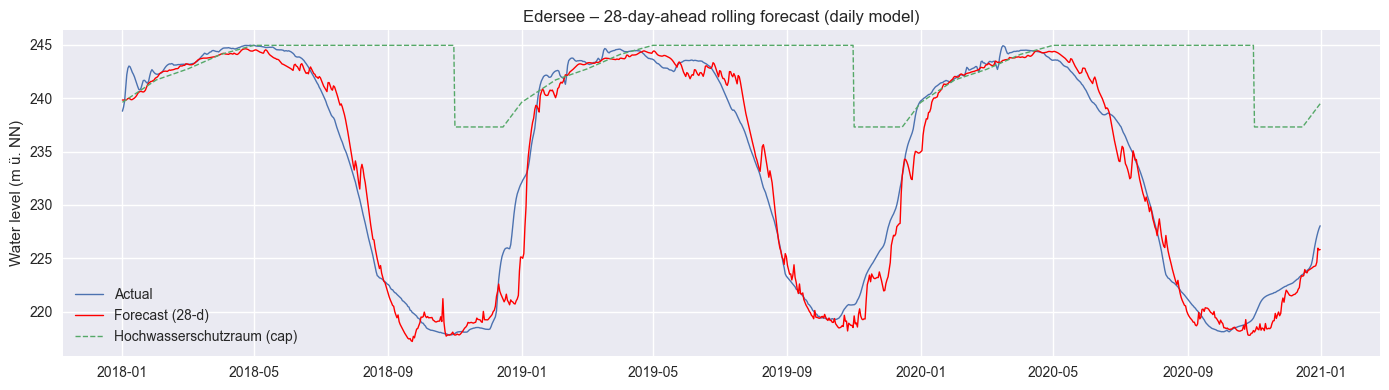

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

# Set style for the plots
plt.style.use('seaborn-v0_8')

# ------------------------------------------------------------------
# 1. Check that the required artefacts and data are available
# ------------------------------------------------------------------
DATA_PATH   = Path("../data/processed/water_levels_daily.csv")
WEATHER_PATH = Path("../data/raw/edersee_historical_weather.csv")
MODEL_PATH  = Path("../models/water_level_lstm.keras")
SCALER_PATH = Path("../models/LSTM_standard_scaler.joblib")

missing = [p for p in [DATA_PATH, MODEL_PATH, SCALER_PATH] if not p.exists()]
if missing:
    raise FileNotFoundError(
        "The following file(s) are missing from the working directory:\n"
        + "\n".join(f" • {m}" for m in missing)
        + "\nPlease upload them and re-run this cell."
    )

# ------------------------------------------------------------------
# 2. Re-create the deterministic feature engineering pipeline
# ------------------------------------------------------------------
LOOKBACK = 365   # one year of look-back
HORIZON  = 28    # 28-day forecast horizon

def make_windows(arr: np.ndarray, lookback: int = LOOKBACK, horizon: int = HORIZON):
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback : i, :])
        y.append(arr[i + horizon - 1, 0])   # only the target column
    return np.array(X, dtype="float32"), np.array(y, dtype="float32")

anchor_template = [
    ("11-01", 237.30),  # 1 Nov
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),  # 1 May
]

def compute_max_level_series(dates):
    def cap_on(day: pd.Timestamp) -> float:
        y0 = day.year if day.month >= 11 else day.year - 1
        pts = []
        for mm_dd, lvl in anchor_template:
            mm, dd  = map(int, mm_dd.split("-"))
            yr      = y0 if mm >= 11 else y0 + 1
            try:
                pts.append((pd.Timestamp(yr, mm, dd), lvl))
            except ValueError:          # 29 Feb on non-leap year
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])

        # outside 1 Nov ↔ 1 May window: reservoir may be full
        if day < pts[0][0] or day >= pts[-1][0]:
            return pts[-1][1]

        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= day <= d1:
                frac = (day - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        # fallback
        return pts[-1][1]

    return pd.Series([cap_on(d) for d in dates], index=dates, name="max_level_m")


# ------------------------------------------------------------------
# 3. Load raw data and build daily feature frame
# ------------------------------------------------------------------
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])

daily = (
    df.set_index("timestamp")["value"]
      .resample("D").mean()
      .interpolate()
)

daily_df = daily.to_frame(name="value")

# Annual cycle (≈365.25 days)
doy     = daily_df.index.dayofyear
ang_yr  = 2 * np.pi * doy / 365.25
daily_df["sin365"] = np.sin(ang_yr)
daily_df["cos365"] = np.cos(ang_yr)


weather_raw = (
    pd.read_csv(
        WEATHER_PATH,
        skiprows=3,                       # first 2 meta lines + blank line
        parse_dates=["time"],
    )
    .rename(columns={"time": "timestamp"})
)

cols = {
    "precipitation_sum (mm)"        : "precip_mm",
    "temperature_2m_mean (°C)"      : "t_mean",
}

weather = (
    weather_raw
      .loc[:, ["timestamp", *cols.keys()]]
      .rename(columns=cols)
      .set_index("timestamp")
      .sort_index()
      .resample("D").mean()
      .interpolate(limit=7)               # close small gaps
)

# 3.3  merge with lake-level df
daily_df = daily_df.join(weather, how="left")

# 3.4  fill any residual NaNs (edge of rolling windows)
daily_df = daily_df.interpolate(limit_direction="both")

# ------------------------------------------------------------------
# 4. Train / validation split (fixed to reproduce original)
# ------------------------------------------------------------------
train_df      = daily_df.loc[: "2017-12-31"]
validation_df = daily_df.loc["2018-01-01" : "2020-12-31"]

# ------------------------------------------------------------------
# 5. Re-apply the stored StandardScaler
# ------------------------------------------------------------------
scaler = joblib.load(SCALER_PATH)

train_scaled      = scaler.transform(train_df)
validation_scaled = scaler.transform(validation_df)

# ------------------------------------------------------------------
# 6. Build validation windows (need padding from tail of train)
# ------------------------------------------------------------------
PAD_LEN  = LOOKBACK + HORIZON - 1
val_block = np.vstack([train_scaled[-PAD_LEN:], validation_scaled])
X_val, y_val = make_windows(val_block)

# ------------------------------------------------------------------
# 7. Load the trained LSTM model and generate predictions
# ------------------------------------------------------------------
model = tf.keras.models.load_model(MODEL_PATH)

val_pred_scaled = model.predict(X_val, verbose=0).flatten()

# Inverse transform for the target
target_mean  = scaler.mean_[0]
target_scale = scaler.scale_[0]

pred_final = val_pred_scaled * target_scale + target_mean
val_true = y_val * target_scale + target_mean

# ------------------------------------------------------------------
# 8. Apply minimum constraint and dynamic Hochwasserschutzraum cap
# ------------------------------------------------------------------
MIN_VAL   = 205.0
dyn_cap   = compute_max_level_series(validation_df.index).values

# ------------------------------------------------------------------
# 9. Compute metrics
# ------------------------------------------------------------------
mae  = mean_absolute_error(val_true, pred_final)
rmse = np.sqrt(mean_squared_error(val_true, pred_final))

print("-" * 50)
print(f"Validation MAE  : {mae:6.4f} m")
print(f"Validation RMSE : {rmse:6.4f} m")
print("-" * 50)

# ------------------------------------------------------------------
# 10. Plot forecast vs. actuals & cap
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(validation_df.index, val_true, label="Actual", linewidth=1)
ax.plot(validation_df.index, pred_final, label="Forecast (28-d)", linewidth=1, color="red")
ax.plot(validation_df.index, dyn_cap, label="Hochwasserschutzraum (cap)", linestyle="--", linewidth=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee – 28-day-ahead rolling forecast (daily model)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Save predictions to CSV
predictions_df = pd.DataFrame({
    "Actual"   : val_true,
    "Predicted": pred_final,
}, index=validation_df.index)
predictions_df.to_csv("../output/predictions/LSTM_predictions.csv", index=True)